In [2]:
#!pip install torch torchvision pillow numpy pandas scikit-learn matplotlib seaborn tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from google.colab import drive

drive.mount('/content/drive')
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Mounted at /content/drive
Using device: cuda


In [3]:
import urllib.request
import zipfile
import json

dataset_path = Path('/content/drive/MyDrive/confirmed_fronts')
dataset_path.mkdir(exist_ok=True)


In [4]:
class DVMColorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
base_dir = '/content/drive/MyDrive/confirmed_fronts'
image_files = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)
            image_files.append(full_path)

print(f"Total images found: {len(image_files)}")

def parse_image_info(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('$$')
    if len(parts) >= 4:
        brand = parts[0]
        year = parts[2]
        color = parts[3]
        return brand, year, color, filepath
    return None, None, None, None

data = []
for path in image_files:
    brand, year, color, full_path = parse_image_info(path)
    if color is not None:
        data.append({
            'brand': brand,
            'year': year,
            'color': color,
            'full_path': full_path
        })

metadata_df = pd.DataFrame(data)
print(f"After parsing colors: {len(metadata_df)}")

metadata_df['file_exists'] = metadata_df['full_path'].apply(os.path.exists)
print(f"Existing files: {metadata_df['file_exists'].sum()}")
metadata_df = metadata_df[metadata_df['file_exists']].copy()
print(f"Files after filtering: {len(metadata_df)}")

class_counts = metadata_df['color'].value_counts()
print("Classes with fewer than 2 samples:")
print(class_counts[class_counts < 2])

valid_classes = class_counts[class_counts >= 2].index
metadata_df = metadata_df[metadata_df['color'].isin(valid_classes)].copy()

print(f"\nAfter filtering rare classes: {len(metadata_df)} samples")
print(f"Number of classes remaining: {len(valid_classes)}")

color_to_idx = {color: idx for idx, color in enumerate(sorted(valid_classes))}
idx_to_color = {idx: color for color, idx in color_to_idx.items()}
num_classes = len(color_to_idx)
print(f"Number of color classes: {num_classes}")

metadata_df['label'] = metadata_df['color'].map(color_to_idx)

image_paths = metadata_df['full_path'].values
labels = metadata_df['label'].values

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTrain samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

Total images found: 61827
After parsing colors: 61827
Existing files: 61827
Files after filtering: 61827
Classes with fewer than 2 samples:
color
Navy      1
Indigo    1
Name: count, dtype: int64

After filtering rare classes: 61825 samples
Number of classes remaining: 21
Number of color classes: 21

Train samples: 49460
Validation samples: 12365


In [6]:

train_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [34]:
batch_size = 512

train_dataset = DVMColorDataset(train_paths, train_labels, transform=train_transform)
val_dataset = DVMColorDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)


In [17]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        out = self.relu(out)
        return out


class CustomResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(CustomResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def create_custom_resnet18(num_classes):
    return CustomResNet(BasicBlock, [2, 2, 2, 2], num_classes)


model_scratch = create_custom_resnet18(num_classes).to(device)
print(f"Custom ResNet18 created with {num_classes} classes")
print(f"Number of parameters: {sum(p.numel() for p in model_scratch.parameters()):,}")

Custom ResNet18 created with 21 classes
Number of parameters: 11,187,285


In [18]:
pretrained_model1 = models.resnet50(pretrained=True)
pretrained_model1.fc = nn.Linear(pretrained_model1.fc.in_features, num_classes)
pretrained_model1 = pretrained_model1.to(device)

pretrained_model2 = models.efficientnet_b0(pretrained=True)
pretrained_model2.classifier[1] = nn.Linear(
    pretrained_model2.classifier[1].in_features, num_classes
)
pretrained_model2 = pretrained_model2.to(device)

print("Pretrained models loaded:")
print(f"1. ResNet50 (ImageNet) - parameters: {sum(p.numel() for p in pretrained_model1.parameters()):,}")
print(f"2. EfficientNet-B0 (ImageNet) - parameters: {sum(p.numel() for p in pretrained_model2.parameters()):,}")

Pretrained models loaded:
1. ResNet50 (ImageNet) - parameters: 23,551,061
2. EfficientNet-B0 (ImageNet) - parameters: 4,034,449


In [19]:
def train_epoch(model, train_loader, criterion, optimizer, device, scaler, scheduler=None):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc='Training')

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1

In [20]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1, all_preds, all_labels

In [21]:
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs, model_name):
    best_f1 = 0.0
    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device, scaler, scheduler)

        val_loss, val_f1, _, _ = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f'{model_name}_best.pth')
            print(f'Best model saved with F1: {best_f1:.4f}')

    return history, best_f1

In [22]:
num_epochs = 20
max_learning_rate = 0.1

criterion = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(
    model_scratch.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

scheduler_scratch = optim.lr_scheduler.OneCycleLR(
    optimizer_scratch,
    max_lr=0.1,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,           # 30% времени на разогрев
    div_factor=10.0,
    final_div_factor=100.0
)

print("Starting training with SGD + OneCycleLR")
history_scratch, best_f1_scratch = train_model(
    model_scratch, train_loader, val_loader, criterion,
    optimizer_scratch, scheduler_scratch, num_epochs, 'custom_resnet18_sgd_onecycle'
)

Starting training with SGD + OneCycleLR

Epoch 1/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [19:07<00:00, 45.90s/it]


Train Loss: 1.2780, Train F1: 0.2264
Val Loss: 1.3893, Val F1: 0.2383
Best model saved with F1: 0.2383

Epoch 2/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


Train Loss: 0.8386, Train F1: 0.3267
Val Loss: 1.1412, Val F1: 0.2878
Best model saved with F1: 0.2878

Epoch 3/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


Train Loss: 0.7454, Train F1: 0.3589
Val Loss: 0.7537, Val F1: 0.3502
Best model saved with F1: 0.3502

Epoch 4/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


Train Loss: 0.6961, Train F1: 0.3726
Val Loss: 0.8085, Val F1: 0.3426

Epoch 5/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:47<00:00,  1.92s/it]


Train Loss: 0.6277, Train F1: 0.4053
Val Loss: 0.6909, Val F1: 0.3843
Best model saved with F1: 0.3843

Epoch 6/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


Train Loss: 0.5803, Train F1: 0.4236
Val Loss: 0.7554, Val F1: 0.3901
Best model saved with F1: 0.3901

Epoch 7/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


Train Loss: 0.5391, Train F1: 0.4511
Val Loss: 0.7079, Val F1: 0.4120
Best model saved with F1: 0.4120

Epoch 8/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


Train Loss: 0.4910, Train F1: 0.4867
Val Loss: 0.7288, Val F1: 0.4125
Best model saved with F1: 0.4125

Epoch 9/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


Train Loss: 0.4497, Train F1: 0.5086
Val Loss: 0.6865, Val F1: 0.4312
Best model saved with F1: 0.4312

Epoch 10/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


Train Loss: 0.4144, Train F1: 0.5290
Val Loss: 0.7271, Val F1: 0.4375
Best model saved with F1: 0.4375

Epoch 11/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


Train Loss: 0.3688, Train F1: 0.5711
Val Loss: 0.6602, Val F1: 0.4265

Epoch 12/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


Train Loss: 0.3154, Train F1: 0.6081
Val Loss: 0.6481, Val F1: 0.4768
Best model saved with F1: 0.4768

Epoch 13/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.96s/it]


Train Loss: 0.2716, Train F1: 0.6520
Val Loss: 0.6917, Val F1: 0.4538

Epoch 14/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


Train Loss: 0.2265, Train F1: 0.6862
Val Loss: 0.6943, Val F1: 0.5037
Best model saved with F1: 0.5037

Epoch 15/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train Loss: 0.1743, Train F1: 0.7285
Val Loss: 0.7687, Val F1: 0.4865

Epoch 16/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:47<00:00,  1.92s/it]


Train Loss: 0.1134, Train F1: 0.7772
Val Loss: 0.7758, Val F1: 0.5109
Best model saved with F1: 0.5109

Epoch 17/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


Train Loss: 0.0637, Train F1: 0.8268
Val Loss: 0.7801, Val F1: 0.5222
Best model saved with F1: 0.5222

Epoch 18/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.96s/it]


Train Loss: 0.0340, Train F1: 0.8694
Val Loss: 0.8093, Val F1: 0.5349
Best model saved with F1: 0.5349

Epoch 19/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


Train Loss: 0.0197, Train F1: 0.8786
Val Loss: 0.8212, Val F1: 0.5347

Epoch 20/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Train Loss: 0.0158, Train F1: 0.8811
Val Loss: 0.8185, Val F1: 0.5367
Best model saved with F1: 0.5367


In [23]:
learning_rate_pretrained = 0.001

optimizer_pretrained1 = optim.Adam(
    pretrained_model1.parameters(),
    lr=learning_rate_pretrained
)

scheduler_pretrained1 = optim.lr_scheduler.OneCycleLR(
    optimizer_pretrained1,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0
)

print("Starting fine-tuning pretrained ResNet50 model")
history_pretrained1, best_f1_pretrained1 = train_model(
    pretrained_model1, train_loader, val_loader, criterion,
    optimizer_pretrained1, scheduler_pretrained1, num_epochs, 'resnet50_pretrained'
)

Starting fine-tuning pretrained ResNet50 model

Epoch 1/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Train Loss: 0.8625, Train F1: 0.3481
Val Loss: 0.5753, Val F1: 0.4210
Best model saved with F1: 0.4210

Epoch 2/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Train Loss: 0.5186, Train F1: 0.4716
Val Loss: 0.7491, Val F1: 0.4483
Best model saved with F1: 0.4483

Epoch 3/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


Train Loss: 0.4924, Train F1: 0.4950
Val Loss: 0.7616, Val F1: 0.4109

Epoch 4/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


Train Loss: 0.4546, Train F1: 0.5286
Val Loss: 0.6450, Val F1: 0.4702
Best model saved with F1: 0.4702

Epoch 5/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


Train Loss: 0.3945, Train F1: 0.5611
Val Loss: 0.5993, Val F1: 0.5005
Best model saved with F1: 0.5005

Epoch 6/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train Loss: 0.3444, Train F1: 0.6021
Val Loss: 0.5982, Val F1: 0.4904

Epoch 7/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.96s/it]


Train Loss: 0.3010, Train F1: 0.6454
Val Loss: 0.5365, Val F1: 0.5381
Best model saved with F1: 0.5381

Epoch 8/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


Train Loss: 0.2500, Train F1: 0.6827
Val Loss: 0.8135, Val F1: 0.5090

Epoch 9/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.97s/it]


Train Loss: 0.2113, Train F1: 0.6994
Val Loss: 0.5874, Val F1: 0.5302

Epoch 10/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.96s/it]


Train Loss: 0.1634, Train F1: 0.7379
Val Loss: 0.6180, Val F1: 0.5493
Best model saved with F1: 0.5493

Epoch 11/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Train Loss: 0.1223, Train F1: 0.7946
Val Loss: 0.6701, Val F1: 0.5554
Best model saved with F1: 0.5554

Epoch 12/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train Loss: 0.0857, Train F1: 0.8234
Val Loss: 0.6503, Val F1: 0.5764
Best model saved with F1: 0.5764

Epoch 13/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


Train Loss: 0.0535, Train F1: 0.8499
Val Loss: 0.7249, Val F1: 0.5918
Best model saved with F1: 0.5918

Epoch 14/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train Loss: 0.0346, Train F1: 0.8973
Val Loss: 0.7188, Val F1: 0.5943
Best model saved with F1: 0.5943

Epoch 15/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.02s/it]


Train Loss: 0.0213, Train F1: 0.9520
Val Loss: 0.7599, Val F1: 0.6316
Best model saved with F1: 0.6316

Epoch 16/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Train Loss: 0.0126, Train F1: 0.9642
Val Loss: 0.7500, Val F1: 0.6194

Epoch 17/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


Train Loss: 0.0093, Train F1: 0.9664
Val Loss: 0.7489, Val F1: 0.6190

Epoch 18/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Train Loss: 0.0071, Train F1: 0.9939
Val Loss: 0.7502, Val F1: 0.6205

Epoch 19/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it]


Train Loss: 0.0063, Train F1: 0.9942
Val Loss: 0.7491, Val F1: 0.6218

Epoch 20/20
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.04s/it]

Train Loss: 0.0061, Train F1: 0.9931
Val Loss: 0.7549, Val F1: 0.6196


In [35]:
learning_rate_pretrained = 0.001
num_epochs = 3

optimizer_pretrained2 = optim.Adam(
    pretrained_model2.parameters(),
    lr=learning_rate_pretrained,
    weight_decay=1e-4
)

scheduler_pretrained2 = optim.lr_scheduler.OneCycleLR(
    optimizer_pretrained2,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0
)

print("Starting fine-tuning pretrained EfficientNet-B0 model")
history_pretrained2, best_f1_pretrained2 = train_model(
    pretrained_model2, train_loader, val_loader, criterion,
    optimizer_pretrained2, scheduler_pretrained2, num_epochs, 'efficientnet_b0_pretrained'
)

print(f"\nBest F1-macro for EfficientNet-B0 (pretrained): {best_f1_pretrained2:.4f}")

Starting fine-tuning pretrained EfficientNet-B0 model

Epoch 1/3
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


Train Loss: 0.3774, Train F1: 0.5823
Val Loss: 0.5293, Val F1: 0.5229
Best model saved with F1: 0.5229

Epoch 2/3
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


Train Loss: 0.3137, Train F1: 0.6386
Val Loss: 0.4993, Val F1: 0.5527
Best model saved with F1: 0.5527

Epoch 3/3
------------------------------------------------------------


Validation: 100%|██████████| 25/25 [00:50<00:00,  2.03s/it]

Train Loss: 0.1755, Train F1: 0.7690
Val Loss: 0.4760, Val F1: 0.5715
Best model saved with F1: 0.5715

Best F1-macro for EfficientNet-B0 (pretrained): 0.5715


In [36]:
def evaluate_model(model, dataloader, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f'Evaluating {model_name}'):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    print(f"\n{'='*60}")
    print(f"Results for {model_name}")
    print(f"{'='*60}")
    print(f"F1-macro: {f1_macro:.4f}")
    print(f"F1-weighted: {f1_weighted:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=[idx_to_color[i] for i in range(num_classes)]))

    return f1_macro, f1_weighted, all_preds, all_labels

In [43]:
model_scratch.load_state_dict(torch.load('custom_resnet18_sgd_onecycle_best.pth'))
pretrained_model1.load_state_dict(torch.load('resnet50_pretrained_best.pth'))
pretrained_model2.load_state_dict(torch.load('efficientnet_b0_pretrained_best.pth'))

f1_scratch, _, preds_scratch, labels_scratch = evaluate_model(
    model_scratch, val_loader, device, 'Custom ResNet18 (from scratch)'
)

f1_pretrained1, _, preds_pretrained1, labels_pretrained1 = evaluate_model(
    pretrained_model1, val_loader, device, 'ResNet50 (pretrained)'
)

f1_pretrained2, _, preds_pretrained2, labels_pretrained2 = evaluate_model(
    pretrained_model2, val_loader, device, 'EfficientNet-B0 (pretrained)'
)

Evaluating Custom ResNet18 (from scratch): 100%|██████████| 25/25 [00:50<00:00,  2.01s/it]



Results for Custom ResNet18 (from scratch)
F1-macro: 0.5369
F1-weighted: 0.8448

Classification Report:
              precision    recall  f1-score   support

       Beige       0.68      0.57      0.62       120
       Black       0.87      0.93      0.90      2863
        Blue       0.89      0.87      0.88      1697
      Bronze       0.40      0.27      0.32        66
       Brown       0.54      0.43      0.48       182
    Burgundy       0.00      0.00      0.00         2
        Gold       0.39      0.36      0.38        44
       Green       0.85      0.63      0.72       155
        Grey       0.79      0.80      0.80      1895
     Magenta       0.00      0.00      0.00         2
      Maroon       0.00      0.00      0.00         5
 Multicolour       0.50      0.15      0.24        39
      Orange       0.75      0.68      0.71       112
        Pink       0.83      0.59      0.69        17
      Purple       0.65      0.38      0.48        73
         Red       0.94      0

Evaluating ResNet50 (pretrained): 100%|██████████| 25/25 [00:52<00:00,  2.11s/it]



Results for ResNet50 (pretrained)
F1-macro: 0.6312
F1-weighted: 0.8724

Classification Report:
              precision    recall  f1-score   support

       Beige       0.63      0.71      0.67       120
       Black       0.88      0.97      0.92      2863
        Blue       0.95      0.84      0.89      1697
      Bronze       0.49      0.47      0.48        66
       Brown       0.67      0.60      0.64       182
    Burgundy       0.00      0.00      0.00         2
        Gold       0.48      0.34      0.40        44
       Green       0.86      0.75      0.80       155
        Grey       0.83      0.84      0.84      1895
     Magenta       1.00      0.50      0.67         2
      Maroon       0.33      0.20      0.25         5
 Multicolour       0.27      0.10      0.15        39
      Orange       0.86      0.71      0.78       112
        Pink       1.00      0.76      0.87        17
      Purple       0.85      0.62      0.71        73
         Red       0.95      0.98      

Evaluating EfficientNet-B0 (pretrained): 100%|██████████| 25/25 [00:50<00:00,  2.00s/it]



Results for EfficientNet-B0 (pretrained)
F1-macro: 0.5714
F1-weighted: 0.8677

Classification Report:
              precision    recall  f1-score   support

       Beige       0.67      0.63      0.65       120
       Black       0.89      0.95      0.92      2863
        Blue       0.91      0.88      0.90      1697
      Bronze       0.51      0.35      0.41        66
       Brown       0.64      0.57      0.60       182
    Burgundy       0.00      0.00      0.00         2
        Gold       0.44      0.43      0.44        44
       Green       0.84      0.80      0.82       155
        Grey       0.82      0.83      0.83      1895
     Magenta       0.00      0.00      0.00         2
      Maroon       0.00      0.00      0.00         5
 Multicolour       0.20      0.03      0.05        39
      Orange       0.77      0.68      0.72       112
        Pink       0.87      0.76      0.81        17
      Purple       0.73      0.66      0.69        73
         Red       0.95      0.9

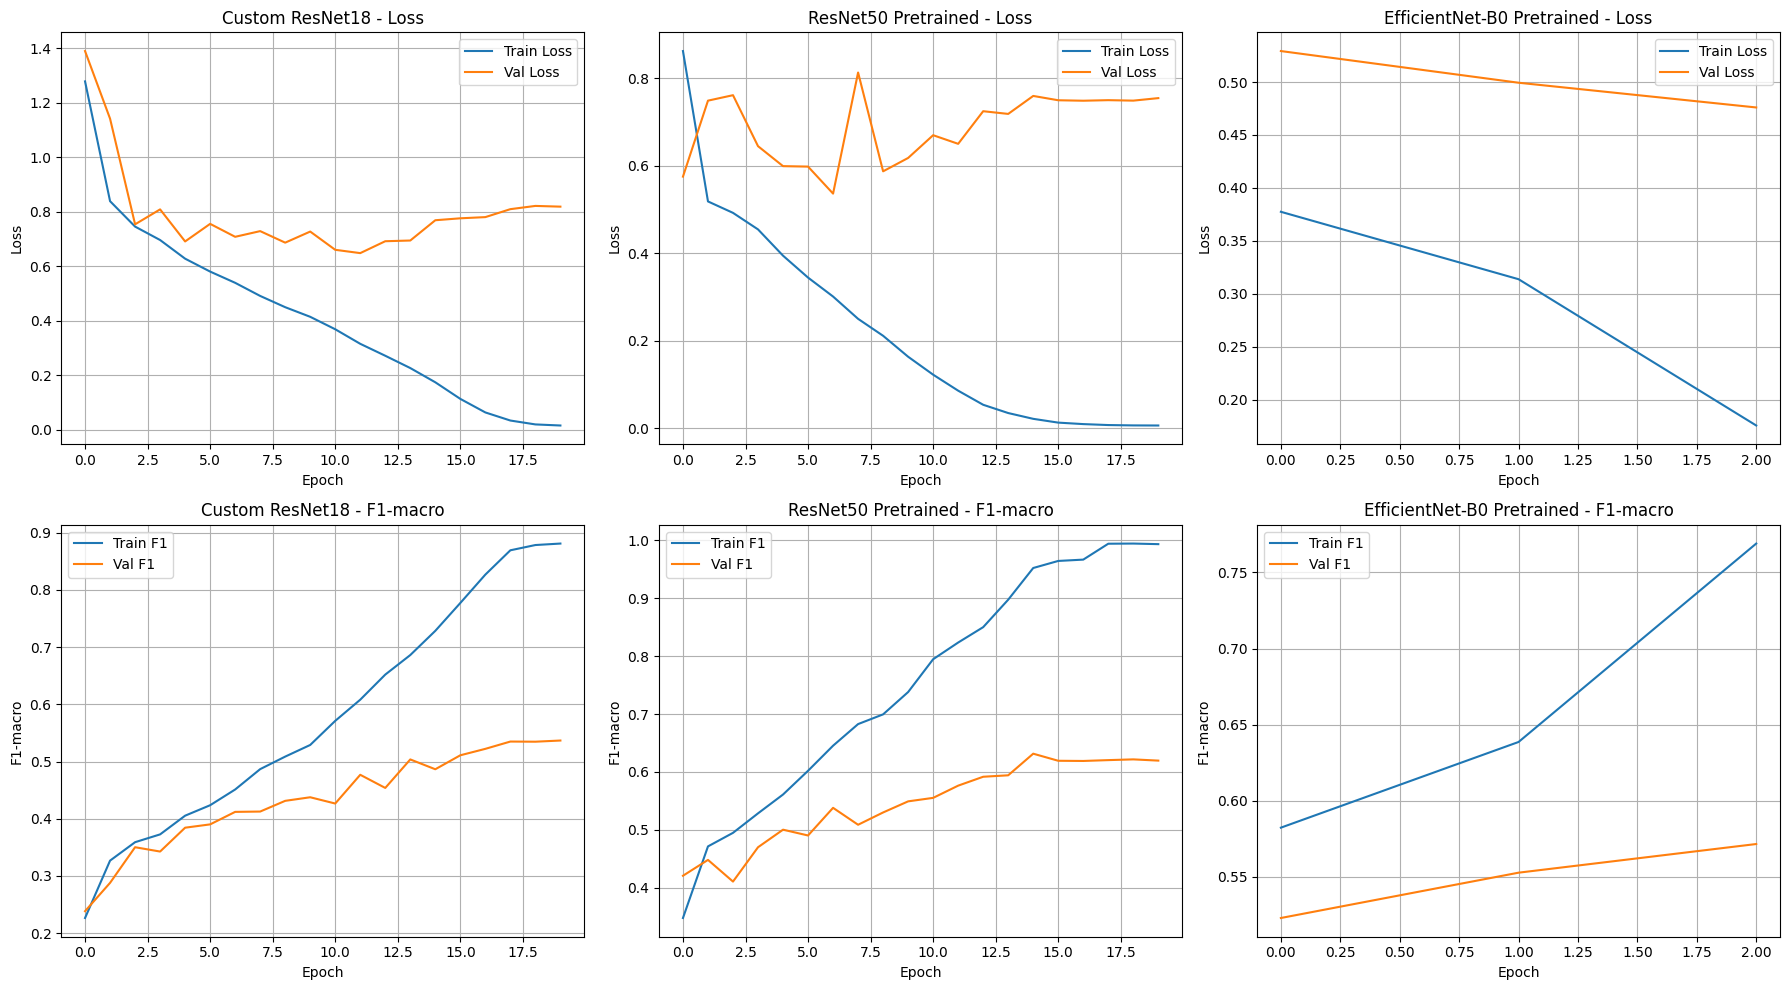

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = [history_scratch, history_pretrained1, history_pretrained2]
titles = ['Custom ResNet18', 'ResNet50 Pretrained', 'EfficientNet-B0 Pretrained']

for i, (history, title) in enumerate(zip(histories, titles)):
    axes[0, i].plot(history['train_loss'], label='Train Loss')
    axes[0, i].plot(history['val_loss'], label='Val Loss')
    axes[0, i].set_title(f'{title} - Loss')
    axes[0, i].set_xlabel('Epoch')
    axes[0, i].set_ylabel('Loss')
    axes[0, i].legend()
    axes[0, i].grid(True)

    axes[1, i].plot(history['train_f1'], label='Train F1')
    axes[1, i].plot(history['val_f1'], label='Val F1')
    axes[1, i].set_title(f'{title} - F1-macro')
    axes[1, i].set_xlabel('Epoch')
    axes[1, i].set_ylabel('F1-macro')
    axes[1, i].legend()
    axes[1, i].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

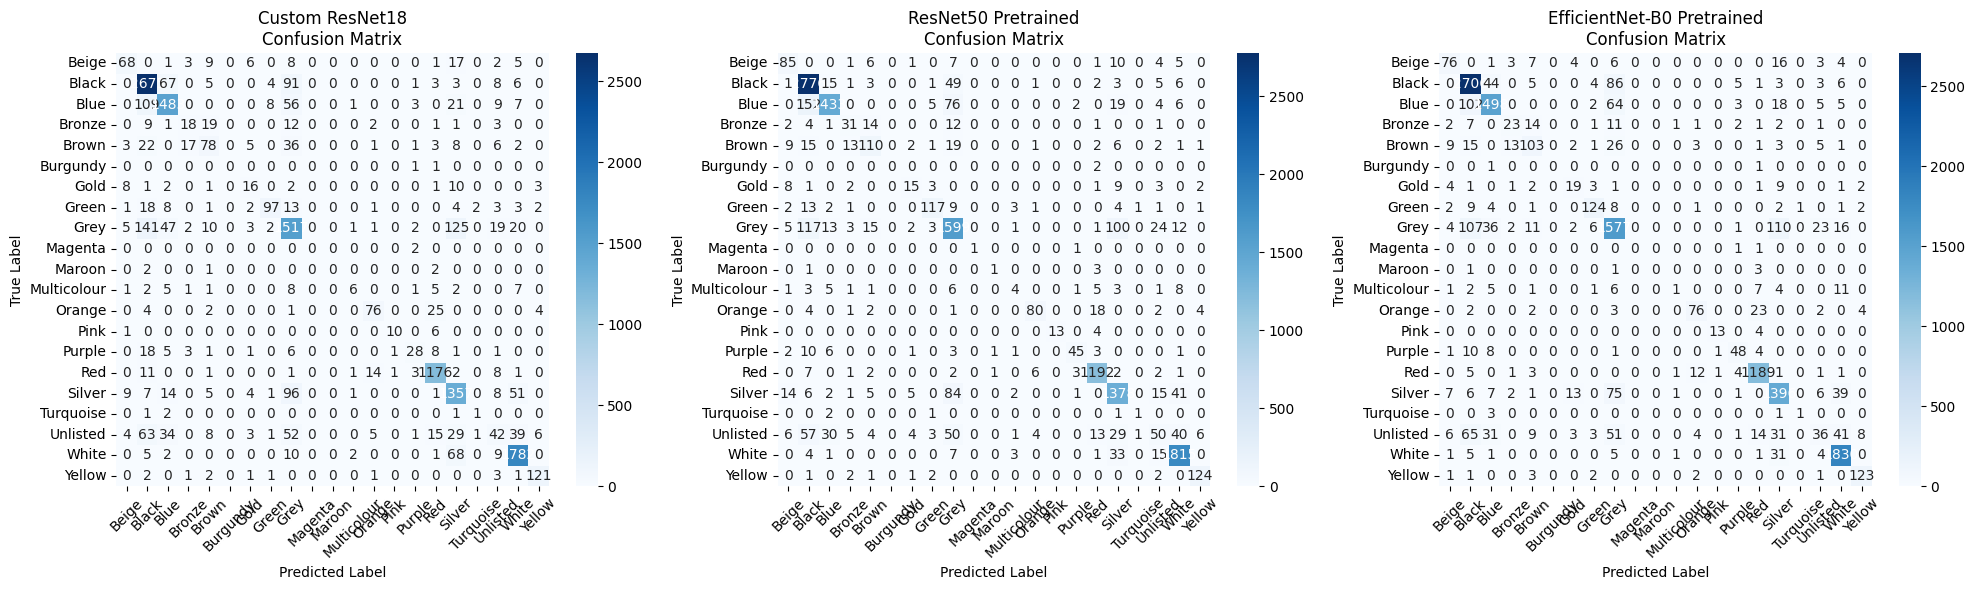

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

predictions = [preds_scratch, preds_pretrained1, preds_pretrained2]
labels_list = [labels_scratch, labels_pretrained1, labels_pretrained2]

for i, (preds, labels, title) in enumerate(zip(predictions, labels_list, titles)):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=[idx_to_color[j] for j in range(num_classes)],
                yticklabels=[idx_to_color[j] for j in range(num_classes)])
    axes[i].set_title(f'{title}\nConfusion Matrix')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300)
plt.show()